<a href="https://colab.research.google.com/github/Mortiniera/Data_Science_Portfolio/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from matplotlib import image
from PIL import Image
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import pandas as pd
tf.test.gpu_device_name()

'/device:GPU:0'

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


[]

In [24]:
chair = glob('gdrive/My Drive/Colab Notebooks/chair/*')
glass = glob('gdrive/My Drive/Colab Notebooks/glass/*')
water_bottle = glob('gdrive/My Drive/Colab Notebooks/water_bottle/*')
size = 299 #Inception uses image sizes of 299 x 299

def add_to_set(subset) :
    images = []
    for filename in subset : 
        image = Image.open(filename)
        if (image.mode != 'RGB'):
            image=image.convert('RGB')
        img_resized = np.array(image.resize((size,size)))
        images.append(img_resized)    
    return images

chair = add_to_set(chair)
glass = add_to_set(glass)
water_bottle = add_to_set(water_bottle)

chair_train, chair_test = train_test_split(chair, test_size=0.2)
glass_train, glass_test = train_test_split(glass, test_size=0.2)
water_bottle_train, water_bottle_test = train_test_split(water_bottle, test_size=0.2)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
def select_indices(d, indices) :
    return [d[i] for i in list(indices)]

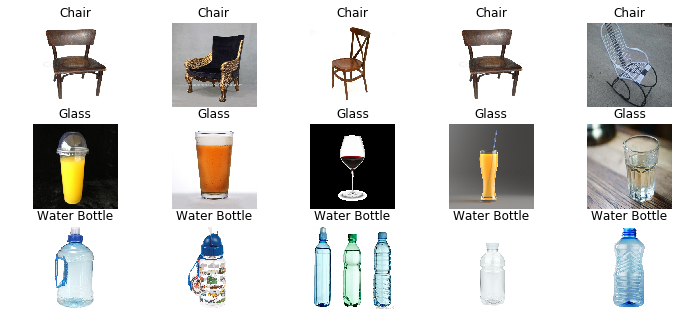

In [26]:
#Visualize some images
chair_visu = select_indices(chair_train, np.random.choice(len(chair_train), 5))
glass_visu = select_indices(glass_train,  np.random.choice(len(glass_train), 5))
water_bottle_visu = select_indices(water_bottle_train, np.random.choice(len(water_bottle_train), 5))
data = np.concatenate((chair_visu, glass_visu, water_bottle_visu))
labels = 5 * ['Chair'] + 5 *['Glass'] + 5 *['Water Bottle']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (im, label) in enumerate(zip(data, labels)):
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [28]:
CLASSES = 3
    
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0807 22:36:59.969291 140337541982080 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


87916544/87910968 [==============================] - 1s 0us/step


In [29]:
X_train = chair_train + glass_train + water_bottle_train
y_train = [0]*len(chair_train) + [1]*len(glass_train) + [2]*len(water_bottle_train)
X_train, y_train = shuffle(np.asarray(X_train), y_train, random_state=42)
y_train = pd.Series(y_train).astype('category')
y_train = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()

X_test = chair_test + glass_test + water_bottle_test
y_test = [0]*len(chair_test) + [1]*len(glass_test) + [2]*len(water_bottle_test)
X_test, y_test = shuffle(np.asarray(X_test), y_test, random_state=42)
y_test = pd.Series(y_test).astype('category')
y_test = pd.get_dummies(y_test.reset_index(drop=True)).as_matrix()




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   # zoom_range = 0.3, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(X_train, y_train, batch_size=100, shuffle=False, seed=10)

In [0]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(X_test, y_test, shuffle=False, batch_size=100, seed=10)

In [32]:
# Train the model
model.fit_generator(train_generator,
                      steps_per_epoch = 175,
                      validation_data = val_generator,
                      validation_steps = 44,
                      epochs = 10,
                      verbose = 2)

Epoch 1/10
175/175 - 284s - loss: 0.2413 - acc: 0.9125 - val_loss: 0.0875 - val_acc: 0.9599
Epoch 2/10
175/175 - 271s - loss: 0.0568 - acc: 0.9827 - val_loss: 0.0784 - val_acc: 0.9586
Epoch 3/10
175/175 - 270s - loss: 0.0341 - acc: 0.9889 - val_loss: 0.0770 - val_acc: 0.9613
Epoch 4/10
175/175 - 269s - loss: 0.0247 - acc: 0.9928 - val_loss: 0.0803 - val_acc: 0.9613
Epoch 5/10
175/175 - 270s - loss: 0.0195 - acc: 0.9933 - val_loss: 0.0792 - val_acc: 0.9608
Epoch 6/10
175/175 - 271s - loss: 0.0193 - acc: 0.9934 - val_loss: 0.0831 - val_acc: 0.9604
Epoch 7/10
175/175 - 271s - loss: 0.0144 - acc: 0.9957 - val_loss: 0.0833 - val_acc: 0.9622
Epoch 8/10
175/175 - 271s - loss: 0.0132 - acc: 0.9956 - val_loss: 0.0826 - val_acc: 0.9608
Epoch 9/10
175/175 - 269s - loss: 0.0134 - acc: 0.9956 - val_loss: 0.0906 - val_acc: 0.9577
Epoch 10/10
175/175 - 270s - loss: 0.0128 - acc: 0.9962 - val_loss: 0.0933 - val_acc: 0.9631
